### TMA4320 - Project 2: Physics


# 0.0 Motivation

In [102]:

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tempfile import TemporaryFile

# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

In [103]:
# Parameters
sigma_0 = 1000 # kg/m^2
sigma = 500 # kg/m^2
R = 10 # m, Radius
A_s = 0.5*np.pi*(R**2) # Cross-section of boat
g = 9.81 # m/s^2
h = (4*R)/(3*np.pi)
m_boat = A_s*sigma

A_0 = (sigma*np.pi*(R**2))/(2*sigma_0)


For å undersøke båtens endring i hellingsvinkel

In [104]:
def calculate_I_c(m_load, s_L):
    '''
    This function calculated the ships total rotational inertia of the ship and its load, at the
    relative position of the load affects the total rotational inertia.
    Input:
        m_load: float, the mass of the load [kg]
        s_L:    float, the loads distance from the metacenter [m]
    Output:
        I_c:    float, the ships total rotational inertia [kg/m²]
    '''
    I_boat = 0.5*m_boat*(R**2)*(1-(32/(9*(np.pi**2)))) # Rotational inertia from the ship about C

    r_load = np.sqrt( h**2 + s_L**2 ) # Distance from ship's CM to load's CM
    I_load = m_load*r_load**2   # Rotational inertia from the load about C 
    
    I_c = I_load + I_boat # Use the superposition property of rotational inertias (Steiner's Thm).
    return I_c


# print(calculate_I_c(0.001*m_boat, 0))
# print(calculate_I_c(0.001*m_boat, R))

In [105]:
def calculate_beta(rhs_constant, x0, tol=1.e-8, max_iter=50):
    ''' Given a right hand side and left hand side of a function and its derivatives, calculates the beta value of the function.
    
    Solve f(x)=0 by Newtons method, 
    
        The output of each iteration is printed
        Input:
        f_lhs: left hand side of function
        df_lhs: left hand side of derivative of function
        f_rhs: right hand side of function
        df_rhs: right hand side of derivative of function
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''

    f = lambda beta: beta - np.sin(beta) - rhs_constant
    df = lambda beta: 1 - np.cos(beta)


    x = x0
    #print(f"k ={0:3d}, x = {x:18.15f}, f(x) = {f(x):10.3e}")
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
        #print(f"k ={k+1:3d}, x = {x:18.15f}, f(x) = {f(x):10.3e}")
    return x

In [106]:
def print_beta():
    f_lhs = lambda beta: beta-np.sin(beta)
    df_lhs = lambda beta: 1 - np.cos(beta)

    f_rhs = lambda beta : np.pi * sigma/sigma_0
    df_rhs = 0

    beta = calculate_beta(np.pi*sigma/sigma_0,5)
    print("Beta = ",round(np.degrees(beta), 2),"degrees")
print_beta()

Beta =  132.35 degrees


In [107]:
#Define the global variables for the equilibrium, as requested in 1b)
y_M_0 = lambda beta: R*np.cos(beta/2)
y_C_0 = lambda beta: y_M_0(beta) - 4*R/(3*np.pi)
y_B_0 = lambda beta: y_M_0(beta) - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = lambda beta: y_M_0(beta) - R

#Values as functions of delta y_C and theta. 
y_M = lambda beta, theta, delta_y_C : y_M_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_C
y_C = lambda beta,delta_y_c : y_C_0(beta) + delta_y_c
y_D = lambda beta, theta, delta_y_c : y_D_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_c
y_B = lambda beta: y_B_0(beta)

#Note: beta is a global variable
gamma = lambda beta, theta, delta_y_c : 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta))+delta_y_c/R)

water_area = lambda gamma_number: 0.5*(R**2)*(gamma_number - np.sin(gamma_number))

F_G = lambda m : -m*g
F_B = lambda A : A*sigma_0*g
friction = lambda k_f, omega, gamma_number : -k_f * R * gamma_number*omega


## 0.? Visualisering av data

For å analysere opparbeidete resultater er det hensiktsmessig å visualisere det i plot. Derfor definerer vi en fleksibel funksjon som plotter datasett på en foretrukket måte. Denne vil bli brukt gjennomgående i rapporten.


# 1.3 Euler metoden


In [108]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    w_new = w + h_step*f(t, w)
    return t,w_new

In [109]:
def solve_ODE(f, t_0, t_end, w_0, h_step, method):
    '''
    Funksjon som løser diff-liking ved å benytte Euler-metoden.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_step: steglengde
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    w_num = np.array([w_0])  
    t_num = np.arange(t_0, t_end + h_step, h_step)   
    t,w_n = method(f, t_num[0], w_num[0], h_step)
    w_num = np.concatenate((w_num, np.array([w_n])))
    for i in range(1,len(t_num)-1):#ikke inkl første element
        if t_num[-1] > t_end- 1.0e-10: #For å treffe endepunktet. 10e-10 for å unngå "truncation error"
            t_num[-1] = t_end
        
        t,w_n = method(f, t_num[i], w_num[i], h_step)
        
        w_num = np.concatenate((w_num, np.array([w_n])))
    #print(t_num)
    return t_num, w_num

The function can be calculated by 

In [110]:
def f(t, w):
    const = (A_0 * sigma_0 * g * h)/calculate_I_c(0, 0)
    return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])

In [111]:
def plot(theta_0,omega_0,t_0,t_end,h_step,method):
    return 0

Equating the...

In [112]:
def test_euler():
    theta_0 = np.radians(20)
    omega_0 = 0
    w_0 = np.array([theta_0, omega_0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step,euler_step)

    theta_num = w_num[:,0]
    omega_num = w_num[:,1]


    plt.plot(t_num, theta_num, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()

## Small angle approximation
...

In [113]:
def f(t, w):
    const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])

def f_small_angle(t, w):
    const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    return np.array([w[1], -const*w[0],0,0,0,0,0,0])

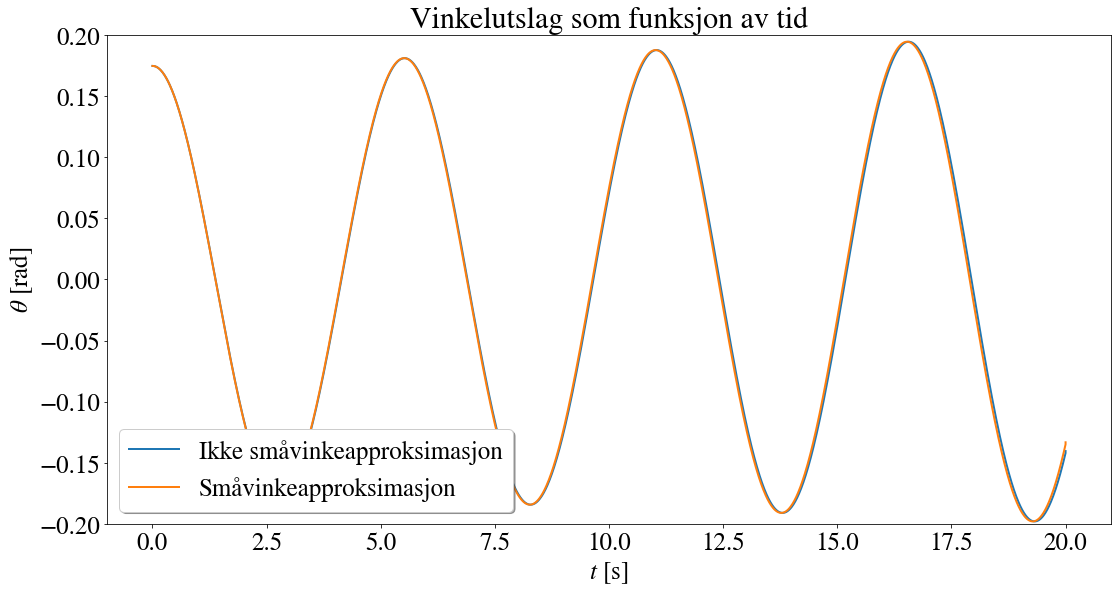

In [114]:
def angle_approx_comparison():

    theta_0 = np.radians(10)
    omega_0 = 0
    w_0 = np.array([theta_0, omega_0,0,0,0,0,0,0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step,euler_step)
    t_num_small_angle_approx, w_num_small_angle_approx = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step,euler_step)


    theta_num = w_num[:,0]
    omega_num = w_num[:,1]
    theta_num_small_angle_approx = w_num_small_angle_approx[:,0]
    omega_num_small_angle_approx = w_num_small_angle_approx[:,1]

    diff = theta_num_small_angle_approx - theta_num    


    plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
    plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
    #plt.plot(t_num, diff, label = "Differanse")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.2,0.2)        
    plt.legend(loc=3, shadow = True)
    plt.show()

angle_approx_comparison()

## 1.3 Runge Kutta metoden

Implementerer fjerde ordens Runge Kutta.


In [115]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''

    k_1 = f(t, w)
    # print(k_1)
    # print(w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h

    return t_new, w_new




In [116]:

def f(t, w):
    const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])

[[ 0.34906585  0.          0.         ...  0.          0.
   0.        ]
 [ 0.34904359 -0.00445167  0.         ...  0.          0.
   0.        ]
 [ 0.34897682 -0.00890279  0.         ...  0.          0.
   0.        ]
 ...
 [-0.27993408  0.2359224   0.         ...  0.          0.
   0.        ]
 [-0.27755693  0.2395038   0.         ...  0.          0.
   0.        ]
 [-0.2751441   0.24305522  0.         ...  0.          0.
   0.        ]]


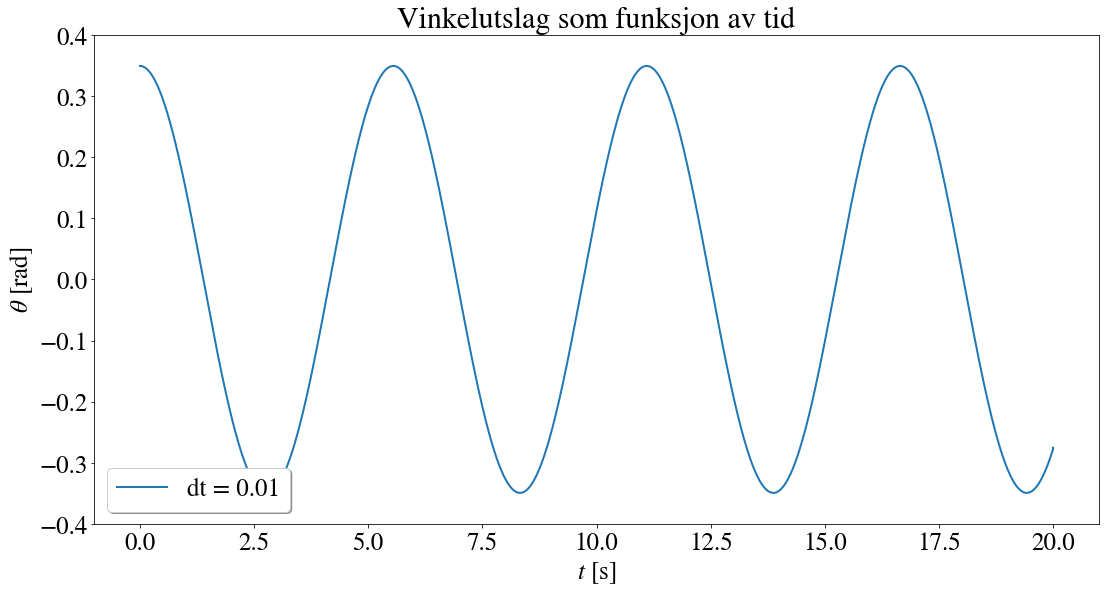

In [117]:
def test_runge_kutta():
    theta_0 = np.radians(20)
    omega_0 = 0
    w_0 = np.array([theta_0, omega_0,0,0,0,0,0,0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    print(w_num_rk4)
    theta_num_rk4 = w_num_rk4[:,0]
    omega_num_rk = w_num_rk4[:,1]


    plt.plot(t_num_rk4, theta_num_rk4, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()
    

test_runge_kutta()

## 1h)
...


In [118]:
def f_analytic(t):
    return 0.01*np.cos(np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))*t)


# To be used in numerical solutions
def f_small_angle(t, w):
    const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    return np.array([w[1], -const*w[0],0,0,0,0,0,0])
def f_not_small_angle(t, w):
    const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    return np.array([w[1], -const*  np.sin(w[0]),0,0,0,0,0,0])

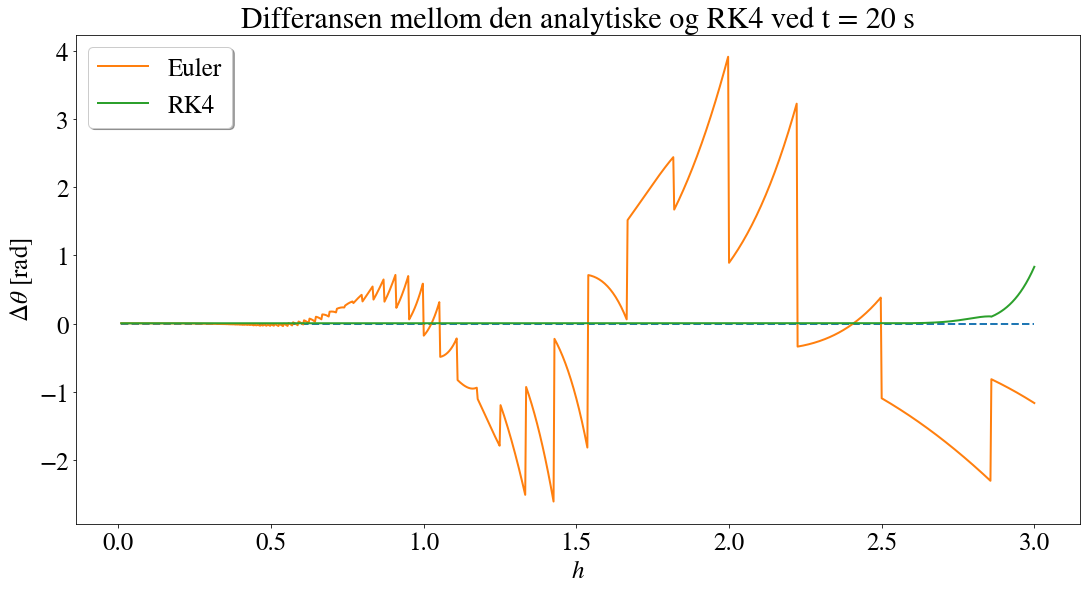

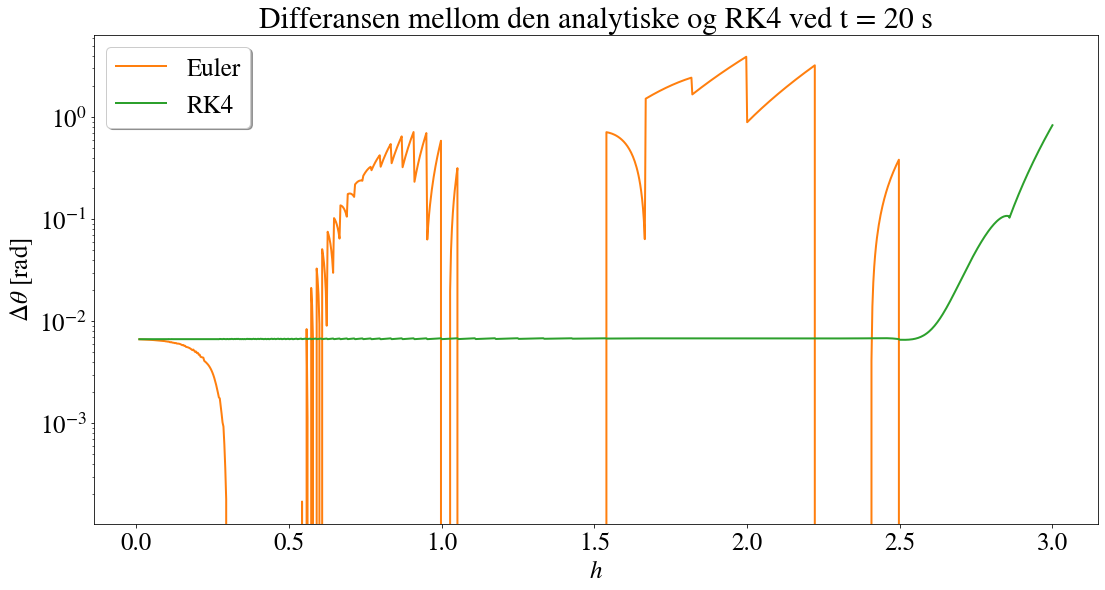

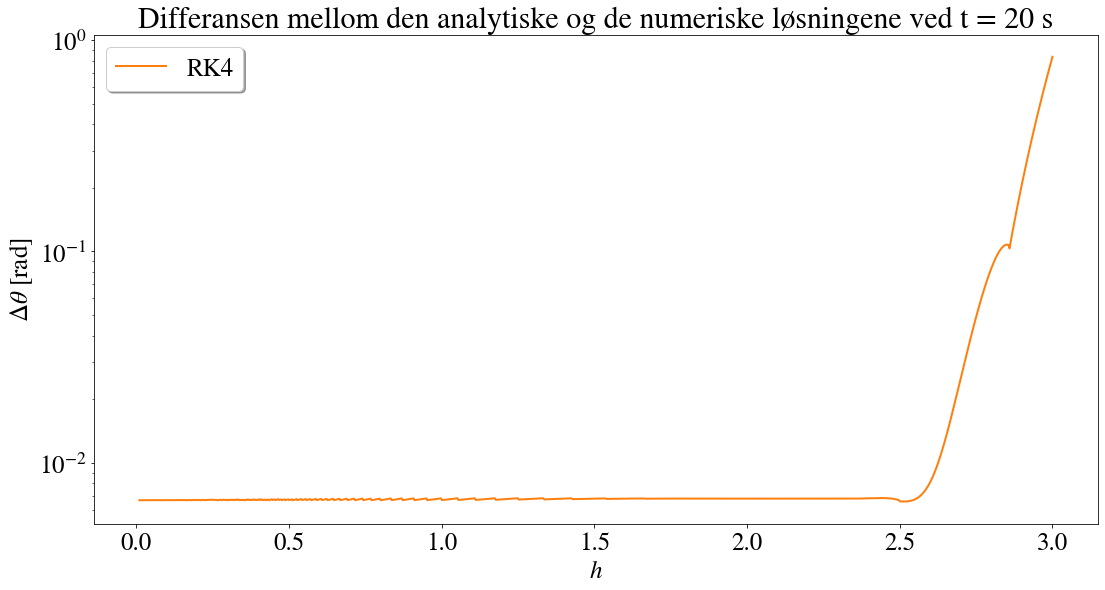

In [119]:
def anal_vs_num():
    theta_0 = np.radians(0.01)
    omega_0 = 0
    w_0 = np.array([theta_0, omega_0,0,0,0,0,0,0])

    t_0 = 0
    t_end = 20

    f_analytic_t_20 = f_analytic(20)

    # Antar det er snakk om h som steglengde
    h_steps = np.linspace(0.01, 3, 1000)

    theta_t20_arr_euler = np.array([])
    theta_t20_arr_rk4 = np.array([])


    for i in range(len(h_steps)):
        result_euler = solve_ODE(f_small_angle, t_0, t_end, w_0, h_steps[i], euler_step)
        result_rk4 = solve_ODE(f_small_angle, t_0, t_end, w_0, h_steps[i], rk4_step)
        theta_t20_arr_euler =np.append(theta_t20_arr_euler, result_euler[1][:,0][-1])
        theta_t20_arr_rk4 = np.append(theta_t20_arr_rk4 ,result_rk4[1][:,0][-1])


    difference_euler = theta_t20_arr_euler-f_analytic_t_20
    difference_rk4 = theta_t20_arr_rk4-f_analytic_t_20
    difference_rk4 = np.abs(difference_rk4)


###############################

    #plt.yscale("log")
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, difference_euler, label = "Euler")
    plt.plot(h_steps, difference_rk4, label = "RK4")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    #plt.ylim(-0.2,0.2)        
    plt.legend(loc=2, shadow = True)
    plt.show()


    plt.yscale("log")
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, difference_euler, label = "Euler")
    plt.plot(h_steps, difference_rk4, label = "RK4")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')

    plt.legend(loc=2, shadow = True)
    plt.show()



###############################


    # print(f_analytic_t_20)
    # x_axis = np.linspace(0,20,len(theta_t20_arr_rk4))
    # plt.plot(x_axis,theta_t20_arr_euler)
    # plt.show()




    plt.yscale("log")

    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0

    plt.plot(h_steps, difference_rk4, label = "RK4")
    print()

    plt.title("Differansen mellom den analytiske og de numeriske løsningene ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    # plt.ylim(-0.2,0.2)                
    plt.legend(loc=2, shadow = True)
    plt.show()

anal_vs_num()

## 2b

In [120]:
# w[0] = theta
# w[1] = omega
# w[2] = x
# w[3] = y
# w[4] = v_x
# w[5] = v_y




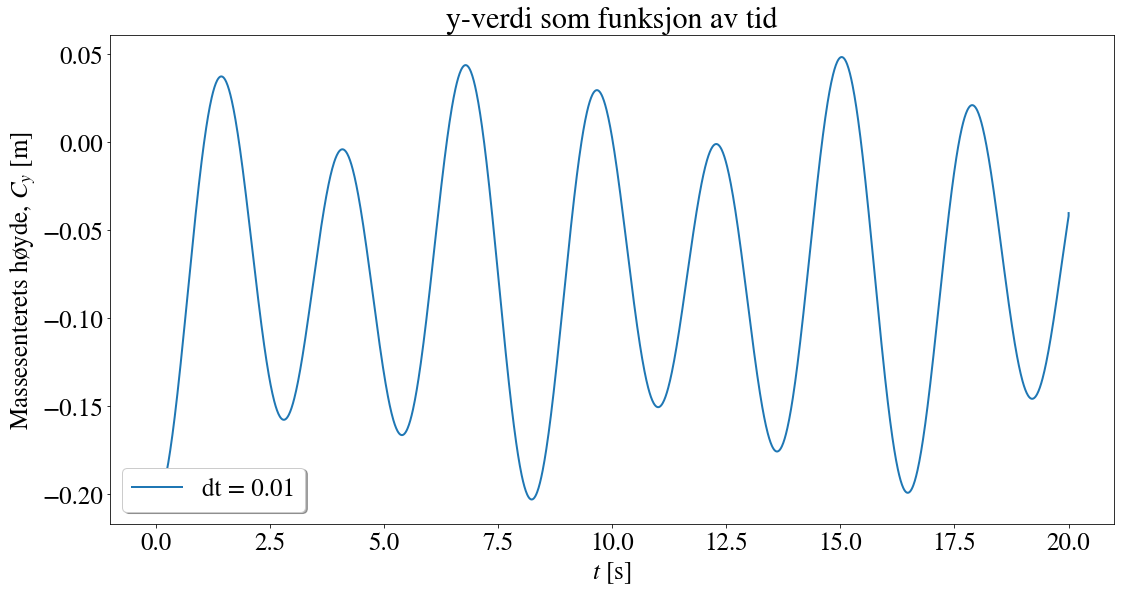

In [121]:
def cm_plot():
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
    
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut de nye verdiene til w-arrayet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            w-arrayet med oppdaterte verdier
        
        '''
    
        delta_y_c_current = w[3] - y_C_0(beta)  
        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        A = water_area(gamma_current)
        return np.array([w[1], -((F_B(A) * h)/calculate_I_c(0, 0))*np.sin(w[0]), w[4], w[5], 0, (F_G(m_boat) + F_B(A))/m_boat,0,0])

    theta_0 = np.radians(20)
    omega_0 = 0
    x_C_0 = 0
    v_x_0 = 0
    v_y_0 = 0

    w_0 = np.array([theta_0, omega_0, x_C_0, y_C_0(beta), v_x_0, v_y_0,0,0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

    y_num_rk4 = w_num_rk4[:,3]
    
    plt.plot(t_num_rk4, y_num_rk4, label = "dt = 0.01")
    plt.title("y-verdi som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

cm_plot()

## Oppg 2c



In [122]:
def check_capsizing(w_num):
    '''
    Checks if the boat is capsizing. 
    Input:
    w_num: array with all the physical properties of the boat
    output:
    w_num: Same array, but now updated values if the boat has capsized.
    
    '''
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta

    theta_arr = w_num[:,0]
    y_arr = w_num[:,3]
    for i in range(len(theta_arr)-1):
        theta_n = theta_arr[i]
        delta_y_n= y_arr[i+1]-y_arr[i]
        delta_y_c_n = y_C(beta,delta_y_n)
        if theta_n > 0.5*(np.pi-gamma(beta,theta_n,delta_y_c_n,)): #Sjekk om båten kantrer
            # print(np.shape(w_num[0].shape))
            # print(w_num[0].shape)
            # print(w_num[0])
            
            theta_arr[i+1] = np.pi/2 * np.sign(theta_arr[i])
            # w_num[0,i] = np.pi/2 * np.sign(w_num[0,i-1]) #Forrige theta-element 
            # print("len")
            # print(len(w_num))
            # print(w_num.ndim)

            # print(w_num)
            # for i in range(1,w_num.ndim):
            #     print(i)
            # print(len(w_num))
            for j in range(1,(len(w_num[0]))):
                w_num[:,j]=0
    return w_num
    

# test_arr = np.zeros((10,4))
# print(test_arr)
# print(len(test_arr[0]))
# test_arr[:,1]=1
# print(test_arr)


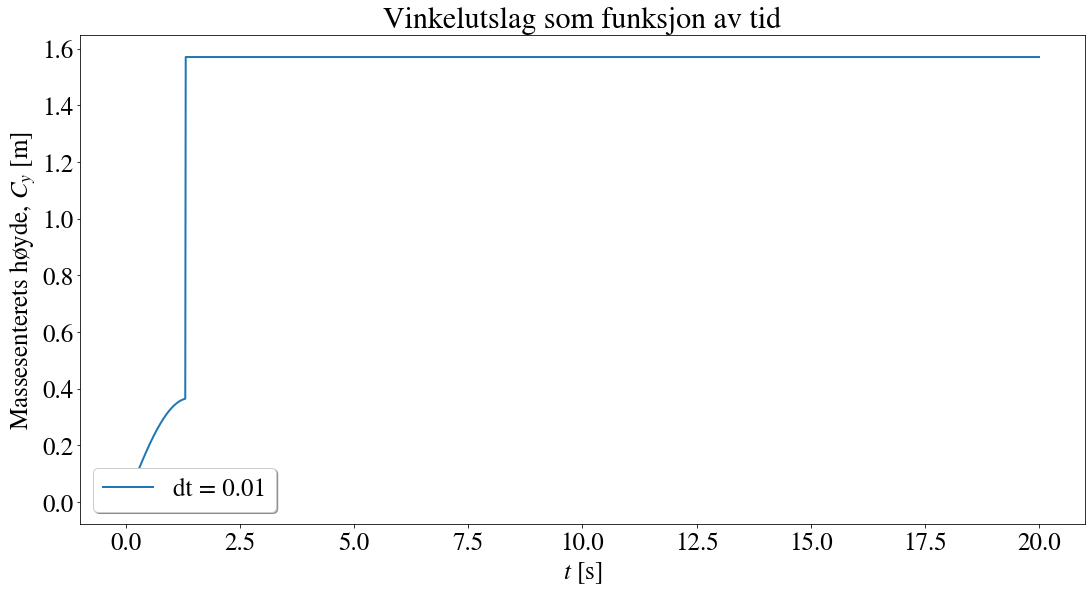

In [123]:
def cm_plot_capsizing():
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
    theta_0 = np.radians(0)
    omega_0 = np.radians(23.78) #Rundt her et sted, men sjekk med newtons metode på ligningen hvis det er mulig
    x_C_0 = 0
    v_x_0 = 0
    v_y_0 = 0

    w_0 = np.array([theta_0, omega_0, x_C_0, y_C_0(beta), v_x_0, v_y_0,0,0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    w_num_rk4 = check_capsizing(w_num_rk4)
    theta_arr = w_num_rk4[:,0]
    np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

    plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

cm_plot_capsizing()

## Oppg 2d

In [128]:
def load_off_boat(w_num):
    s_L=w_num[:,6]
    indexes = np.nonzero(abs(s_L)>R)
    s_L[indexes] = 0

    w_num = np.column_stack((np.column_stack((w_num[:,0:5],s_L)),w_num[:,7]))
    return w_num


a = np.zeros((10,3))
print(a)
b = np.ones(10)
# b = b.transpose()
print(b)
c = np.column_stack((a,b))
print(c)


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


/var/folders/_k/ftngv5t159n1p3wmrs7nk3nc0000gn/T/ipykernel_21300/3621730434.py:22: RuntimeWarning: invalid value encountered in arccos
  gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)


[[ 0.00000000e+00  3.49065850e-03  0.00000000e+00 ...  0.00000000e+00
   3.00000000e+00  0.00000000e+00]
 [ 3.29814135e-05  3.10558379e-03  4.11102065e-10 ...  7.26666667e-03
   2.99999999e+00 -1.64921800e-06]
 [ 6.21109147e-05  2.72028075e-03  3.19552761e-09 ...  1.45333333e-02
   2.99999996e+00 -6.34499503e-06]
 ...
 [-3.18221638e+00 -9.45939800e-02 -8.65661989e+01 ...  2.90521333e+01
   3.73721584e+03  2.12708286e+02]
 [-3.18316231e+00 -9.45920390e-02 -8.65738745e+01 ...  2.90594000e+01
   3.73934290e+03  2.12704255e+02]
 [-3.18410822e+00 -9.45900993e-02 -8.65815531e+01 ...  2.90666667e+01
   3.74146992e+03  2.12700132e+02]]
[[ 0.00000000e+00  3.49065850e-03  0.00000000e+00 ...  0.00000000e+00
   3.00000000e+00  0.00000000e+00]
 [ 3.29814135e-05  3.10558379e-03  4.11102065e-10 ...  1.22164296e-07
   2.99999999e+00 -1.64921800e-06]
 [ 6.21109147e-05  2.72028075e-03  3.19552761e-09 ...  4.69999631e-07
   2.99999996e+00 -6.34499503e-06]
 ...
 [-3.18221638e+00 -9.45939800e-02 -8.6566198

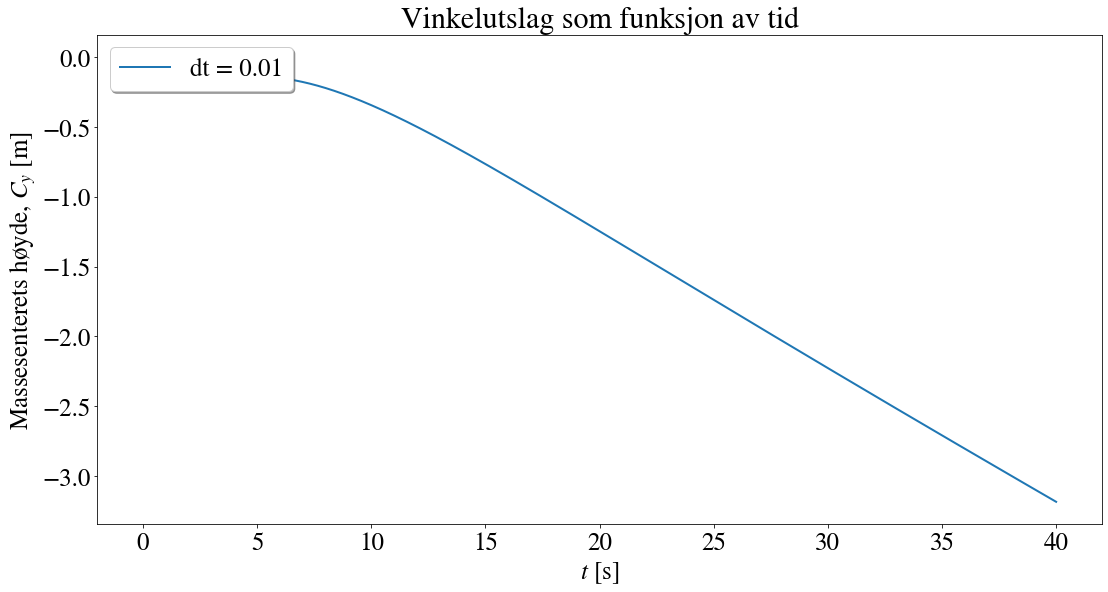

In [130]:
def boat_with_load():
    m_load = 0.08*m_boat #Gjør om til array senere, evt som input til funksjonen
    m_tot = m_boat + m_load
    beta = calculate_beta(np.pi*sigma/sigma_0 + 2*m_load/R**2,5) #Ikke lenger samme som før
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut de nye verdiene til w-arrayet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            w-arrayet med oppdaterte verdier
        
        '''
        
        
        A = (np.pi * R**2 *sigma + 2*m_load)/(2*sigma_0) #eller A_0?
        
        delta_y_c_current = w[3] - y_C_0(beta) 

        I_c = calculate_I_c(m_tot,w[6])
        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        # A = water_area(gamma_current) #gammel
        return np.array([
            w[1],
            (1/I_c) *( -F_B(A) * h * np.sin(w[0]) -m_load*g*np.cos(w[0])*w[6]),
            w[4],
            w[5],
            1/m_tot * (m_load * g*np.cos(w[0])*np.sin(w[0])),
            1/m_tot * (-m_boat * g + A * sigma_0 * g ),
            w[7],
            -g*np.sin(w[0])
              ])


    def plot_with_load():
        
        theta_0 = np.radians(0)
        omega_0 = np.radians(0.2) 
        x_C_0 = 0
        v_x_0 = 0
        v_y_0 = 0
        s_L_0 = 3#
        v_L_0 = 0#

        w_0 = np.array([theta_0, omega_0, x_C_0, y_C_0(beta), v_x_0, v_y_0,s_L_0,v_L_0])

        t_0 = 0
        t_end = 40

        h_step = 0.01

        t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
        print(w_num_rk4)
        w_num_rk4 = load_off_boat(w_num_rk4)#
        print(w_num_rk4)

        w_num_rk4 = check_capsizing(w_num_rk4)

        
        theta_arr = w_num_rk4[:,0]
        y_pos = w_num_rk4[:,3]
        np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

        plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
        plt.title("Vinkelutslag som funksjon av tid")
        plt.xlabel('$t$ [s]')           
        plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
        # plt.ylim(-0.25,0.25)        
        plt.legend(loc=2, shadow = True)
        plt.show()
    plot_with_load()
    
boat_with_load()

# X.0 Conclusion

Lorem Ipsum...